In [29]:
# In this script we recreate figure 2 (cylinders in biomaterial)
# %%
from __future__ import annotations

import jax
import jax.numpy as jnp
from samples import Sample, Source, bio_cylinders
import matplotlib.pyplot as plt
from jax import Array


In [39]:

# %%
wavelength = 1.0
spacing = 0.25
n_sample = bio_cylinders()[::2, :, ::2]
sample = Sample.init(
    n_sample,
    spacing,
    wavelength,
    boundary_type="pbl",
    boundary_width=(25, None, 25),
    boundary_strength=0.35,
)

source = Source(
    field=jnp.zeros((*n_sample.shape, 3)).at[0].set(jnp.array([0, 1, 1])),
    wavelength=wavelength,
)

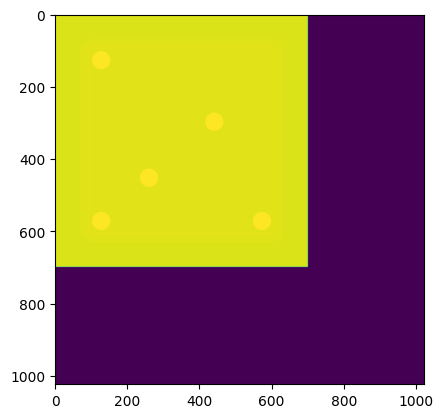

In [31]:
plt.imshow(sample.permittivity[:, 0, :].real)

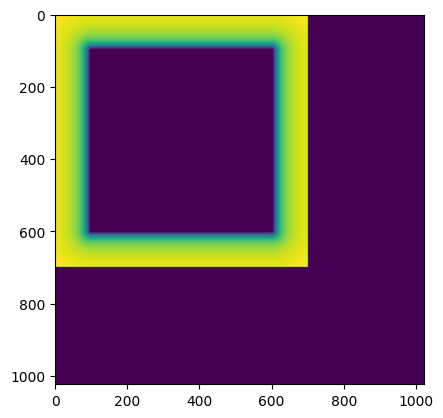

In [32]:
plt.imshow(sample.permittivity[:, 0, :].imag)

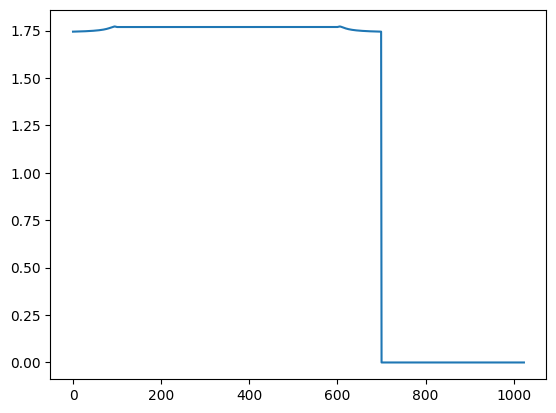

In [33]:
plt.plot(sample.permittivity[500, 0].real)

In [34]:
# In this script we recreate figure 2 (cylinders in biomaterial)
# %%
from __future__ import annotations

import jax
import jax.numpy as jnp
from samples import Sample, Source, vacuum_cylinders, bio_cylinders
import matplotlib.pyplot as plt
from jax import Array

# %%
wavelength = 1.0
spacing = 0.25
n_sample = vacuum_cylinders()
sample = Sample.init(
    n_sample,
    spacing,
    wavelength,
    boundary_type="pbl",
    boundary_width=(25, None, 25),
    boundary_strength=0.35,
)

source = Source(
    field=jnp.zeros((*n_sample.shape, 3)).at[0].set(jnp.array([0, 1, 1])),
    wavelength=wavelength,
)


# %% Making Greens function
def G_fn(k: Array, k0: Array, alpha: Array) -> Array:
    k_sq = jnp.sum(jnp.abs(k) ** 2, axis=-1)[..., None, None]
    k_cross = k[..., :, None] * k[..., None, :] / (alpha * k0**2)
    return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)


def bmatvec(mat: Array, vec: Array) -> Array:
    return jnp.matmul(mat, vec[..., None]).squeeze(-1)


def propagate(G: Array, field: Array) -> Array:
    fft = lambda x: jnp.fft.fftn(x, axes=(0, 1, 2))
    ifft = lambda x: jnp.fft.ifftn(x, axes=(0, 1, 2))

    return ifft(bmatvec(G, fft(field)))


def maxwell_solver(source: Source, sample: Sample, rtol=1e-8, max_iter: int = 1000):
    def update_fn(args):
        field, history, iteration = args

        # New field
        dE = 1j / alpha_imag * V * (propagate(Gk, k0**2 * V * field + _source) - field)

        # Calculating change
        delta = jnp.mean(jnp.abs(dE) ** 2) / jnp.mean(jnp.abs(field) ** 2)

        return field + dE, history.at[iteration].set(delta), iteration + 1

    def cond_fn(args) -> bool:
        _, history, iteration = args
        return (history[iteration - 1] > rtol) & (iteration < max_iter)


    # Getting real part of alpha
    alpha_real = (jnp.min(sample.permittivity) + jnp.max(sample.permittivity)) / 2
    alpha_imag = jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.95
    alpha = alpha_real + 1j * alpha_imag

    # Making greens function and potential
    ks = [
            2 * jnp.pi * jnp.fft.fftfreq(shape, sample.dx) for shape in sample.spatial_shape
        ]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    
    k0 = 2 * jnp.pi / source.wavelength
    Gk = G_fn(k_grid, k0, alpha)
    V = (sample.permittivity - alpha)[..., None]

    # Setting up source
    x_slice, y_slice, z_slice = sample.roi
    _source = jnp.zeros((*sample.shape, 3)).at[x_slice, y_slice, z_slice, :].set(source.source)

    # Running and postprocessing
    init = update_fn((_source, jnp.zeros(max_iter), 0))
    field, history, iteration = jax.lax.while_loop(cond_fn, update_fn, init)
    return field[sample.roi], field, {"error": history, "n_iterations": iteration}


In [35]:
# %%
field, field_full, stats = maxwell_solver(source, sample, max_iter=1000, rtol=1e-7)



Text(0, 0.5, 'x')

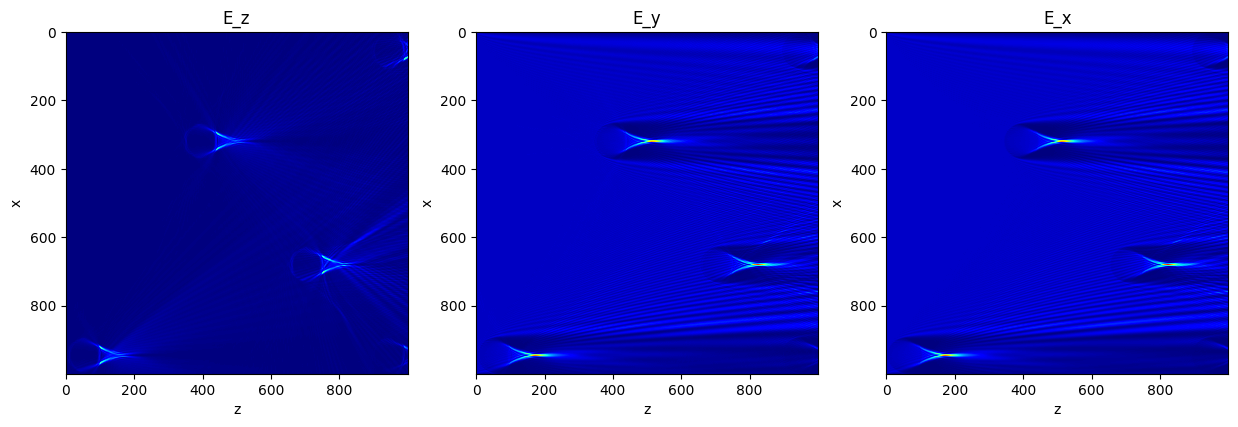

In [36]:
# %%
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(jnp.rot90(jnp.abs(field[:, 0, :, 0]) ** 2), cmap="jet")  # %%
plt.title("E_z")
plt.xlabel("z")
plt.ylabel("x")
# plt.colorbar()

plt.subplot(132)
plt.imshow(jnp.rot90(jnp.abs(field[:, 0, :, 1]) ** 2), cmap="jet")  # %%
plt.title("E_y")
plt.xlabel("z")
plt.ylabel("x")
# plt.colorbar()

plt.subplot(133)
plt.imshow(jnp.rot90(jnp.abs(field[:, 0, :, 2]) ** 2), cmap="jet")  # %%
plt.title("E_x")
plt.xlabel("z")
plt.ylabel("x")
# plt.colorbar()

In [61]:
# In this script we recreate figure 2 (cylinders in biomaterial)
# %%
from __future__ import annotations

import jax
import jax.numpy as jnp
from samples import Sample, Source, vacuum_cylinders, bio_cylinders
import matplotlib.pyplot as plt
from jax import Array

# %%
wavelength = 1.0
spacing = 0.25
n_sample = vacuum_cylinders()
sample = Sample.init(
    n_sample,
    spacing,
    wavelength,
    boundary_type="pbl",
    boundary_width=(25, None, 25),
    boundary_strength=0.35,
)

source = Source(
    field=jnp.zeros((*n_sample.shape, 3)).at[0].set(jnp.array([0, 1, 1])),
    wavelength=wavelength,
)


# %% Making Greens function
def G_fn(k: Array, k0: Array, alpha: Array) -> Array:
    k_sq = jnp.sum(jnp.abs(k) ** 2, axis=-1)[..., None, None]
    k_cross = k[..., :, None] * k[..., None, :] / (alpha * k0**2)
    return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)


def bmatvec(mat: Array, vec: Array) -> Array:
    return jnp.matmul(mat, vec[..., None]).squeeze(-1)


def maxwell_solver(source: Source, sample: Sample, rtol=1e-8, max_iter: int = 1000):
    def propagate(G: Array, field: Array) -> Array:
        fft = lambda x: jnp.fft.fftn(x, axes=(0, 1, 2))
        ifft = lambda x: jnp.fft.ifftn(x, axes=(0, 1, 2))

        return crop(ifft(bmatvec(G, fft(pad(field)))))

    def update_fn(args):
        field, history, iteration = args

        # New field
        dE = 1j / alpha_imag * V * (propagate(Gk, k0**2 * V * field + _source) - field)

        # Calculating change
        delta = jnp.mean(jnp.abs(dE) ** 2) / jnp.mean(jnp.abs(field) ** 2)

        return field + dE, history.at[iteration].set(delta), iteration + 1

    def cond_fn(args) -> bool:
        _, history, iteration = args
        return (history[iteration - 1] > rtol) & (iteration < max_iter)

    def pad(u):
        return jnp.pad(u, ((0, 700), (0, 0), (0, 700), (0, 0)), mode="constant", constant_values=0)
    
    def crop(u):
        return u[:700, :, :700, :]
    
    # Getting shapes
    permittivity = sample.permittivity[:700, :, :700]

    # We padd to twice the shape
    padded_shape = (1400, 1, 1400)


    # Getting real part of alpha
    alpha_real = (jnp.min(permittivity) + jnp.max(permittivity)) / 2
    alpha_imag = jnp.max(jnp.abs(permittivity - alpha_real)) / 0.95
    alpha = alpha_real + 1j * alpha_imag

    
    # Making greens function and potential
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.dx) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    
    k0 = 2 * jnp.pi / source.wavelength
    Gk = G_fn(k_grid, k0, alpha)
    V = (permittivity - alpha)[..., None]

    # Setting up source - plane wave within the full domain
    x_slice, y_slice, z_slice = sample.roi
    _source = jnp.zeros((*permittivity.shape, 3)).at[x_slice, y_slice, z_slice, :].set(source.source[:600, :, :600])

    # Running and postprocessing
    init = update_fn((_source, jnp.zeros(max_iter), 0))
    field, history, iteration = jax.lax.while_loop(cond_fn, update_fn, init)
    return field[sample.roi], field, {"error": history, "n_iterations": iteration}


In [62]:
source.source.shape

(1000, 1, 1000, 3)

In [63]:
# %%
field, field_full, stats = maxwell_solver(source, sample, max_iter=1000, rtol=1e-7)



TypeError: mul got incompatible shapes for broadcasting: (700, 1, 700, 1), (1400, 1, 1400, 3).

Text(0, 0.5, 'x')

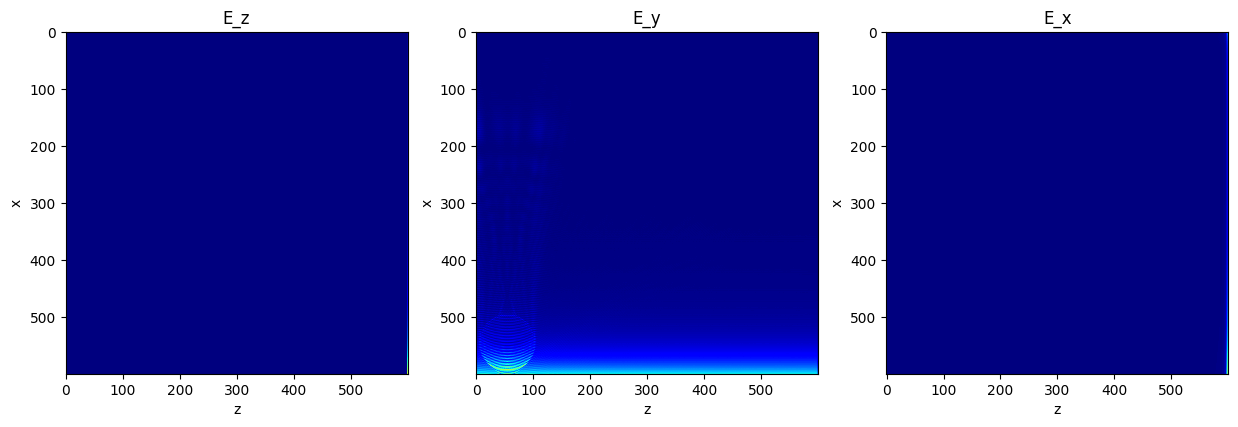

In [49]:
# %%
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(jnp.rot90(jnp.abs(field[:, 0, :, 0]) ** 2), cmap="jet")  # %%
plt.title("E_z")
plt.xlabel("z")
plt.ylabel("x")
# plt.colorbar()

plt.subplot(132)
plt.imshow(jnp.rot90(jnp.abs(field[:, 0, :, 1]) ** 2), cmap="jet")  # %%
plt.title("E_y")
plt.xlabel("z")
plt.ylabel("x")
# plt.colorbar()

plt.subplot(133)
plt.imshow(jnp.rot90(jnp.abs(field[:, 0, :, 2]) ** 2), cmap="jet")  # %%
plt.title("E_x")
plt.xlabel("z")
plt.ylabel("x")
# plt.colorbar()